In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 82.3 MB/s eta 0:00:00


In [ ]:
from pulp import *

**Find the optimal locations of your manufacturing facilities to meet customers’ demands and reduce production costs.**


In [ ]:
manvar_costs = pd.read_excel('variable_costs.xlsx', index_col = 0)
manvar_costs.head()

,USA,Germany,Japan,Brazil,India
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
Germany,13,13,13,13,13
Japan,10,10,10,10,10
Brazil,8,8,8,8,8
India,5,5,5,5,5


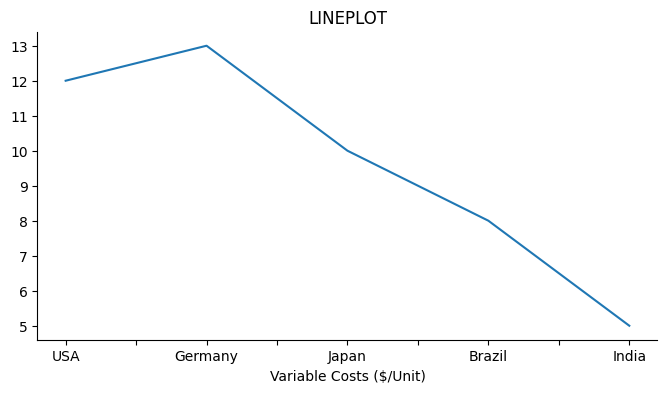

In [ ]:
# @title USA

from matplotlib import pyplot as plt
manvar_costs['USA'].plot(kind='line', figsize=(8, 4), title='LINEPLOT')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:

freight_costs = pd.read_excel('freight_costs.xlsx', index_col = 0)
freight_costs

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,0,12250,1100,16100,8778
Germany,13335,0,8617,20244,10073
Japan,15400,22750,0,43610,14350
Brazil,16450,22050,28000,0,29750
India,13650,15400,24500,29400,0


In [ ]:
var_cost = freight_costs/1000 + manvar_costs

var_cost

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,12.000,24.25,13.100,28.100,20.778
Germany,26.335,13.00,21.617,33.244,23.073
Japan,25.400,32.75,10.000,53.610,24.350
Brazil,24.450,30.05,36.000,8.000,37.750
India,18.650,20.40,29.500,34.400,5.000


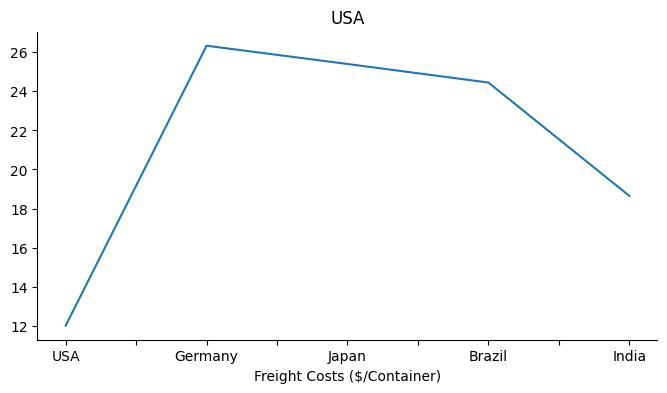

In [ ]:
# @title USA

from matplotlib import pyplot as plt
var_cost['USA'].plot(kind='line', figsize=(8, 4), title='USA')
plt.gca().spines[['top', 'right']].set_visible(False)


In [ ]:
fixed_costs = pd.read_excel('fixed_cost.xlsx', index_col = 0)
fixed_costs

,Low,High
USA,6500,9500
Germany,4980,7270
Japan,6230,9100
Brazil,3230,4730
India,2110,6160


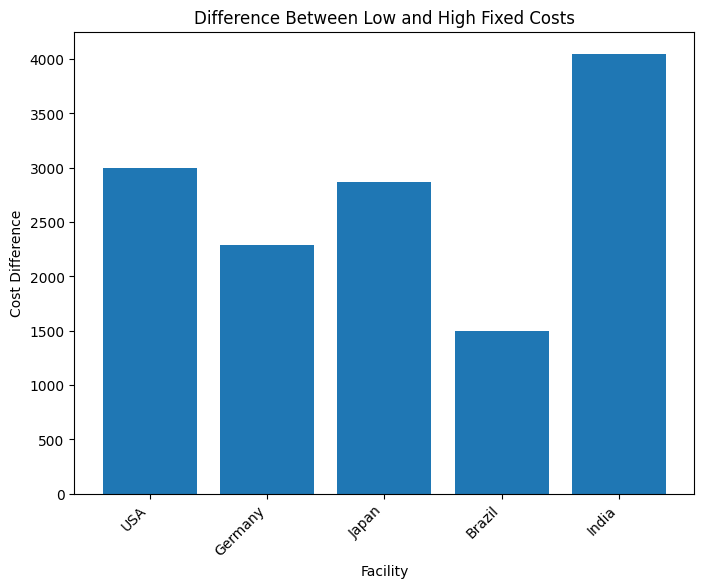

In [ ]:
# @title Difference Between Low and High Fixed Costs

import matplotlib.pyplot as plt

# Calculate the difference between High and Low costs
difference = fixed_costs['High'] - fixed_costs['Low']

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(fixed_costs.index, difference)

# Add labels and title
plt.xlabel('Facility')
plt.ylabel('Cost Difference')
plt.title('Difference Between Low and High Fixed Costs')

# Rotate x-axis labels for better readability
_ = plt.xticks(rotation=45, ha='right')

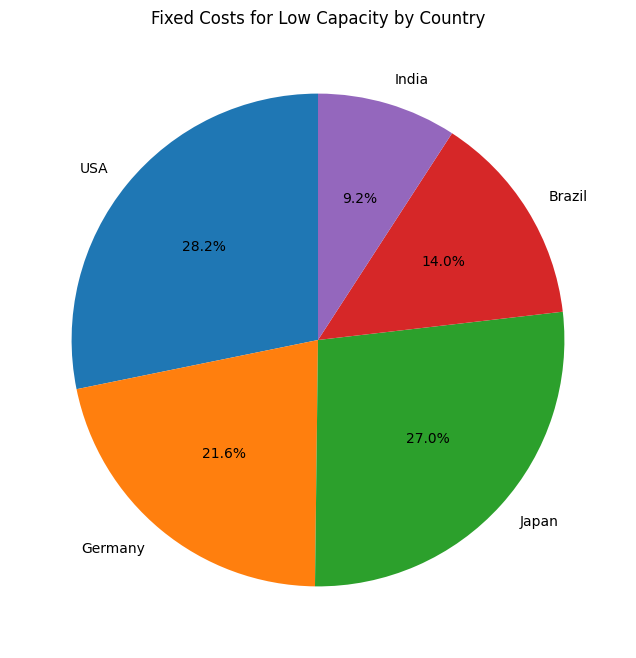

In [ ]:
low_fixed_costs = fixed_costs['Low']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(low_fixed_costs, labels=low_fixed_costs.index, autopct='%1.1f%%', startangle=90)
plt.title('Fixed Costs for Low Capacity by Country')
plt.show()

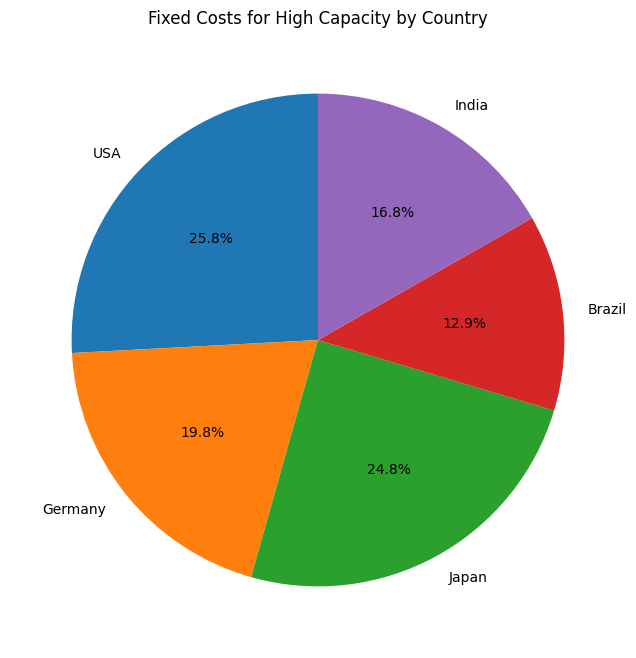

In [ ]:
low_fixed_costs = fixed_costs['High']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(low_fixed_costs, labels=low_fixed_costs.index, autopct='%1.1f%%', startangle=90)
plt.title('Fixed Costs for High Capacity by Country')
plt.show()

In [ ]:
cap = pd.read_excel('capacity.xlsx', index_col = 0)
cap

,Low,High
Capacity (kUnits/month),,
USA,500,1500
Germany,500,1500
Japan,500,1500
Brazil,500,1500
India,500,3000


In [ ]:
demand = pd.read_excel('demand.xlsx', index_col = 0)
demand

,Unnamed: 1,Unnamed: 2
NaN,(Units/month),Demand
NaN,USA,2800000
NaN,Germany,90000
NaN,Japan,1700000
NaN,Brazil,145000
NaN,India,160000


In [ ]:
loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
size = ['Low', 'High']

# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)


# Create Decision Variables
x = LpVariable.dicts("production_", [(i,j) for i in loc for j in loc],
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_",
                     [(i,s) for s in size for i in loc], cat='Binary')

# Define Objective Function
model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))
demand.index = demand['Unnamed: 1']  # Set 'Unnamed: 1' column as the index
demand = demand.drop(columns=['Unnamed: 1'])  # Drop this column if desired
demand = demand.rename(columns={'Unnamed: 2': 'Demand'}) # Rename 'Unnamed: 2' to 'Demand'
# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                       for s in size])


# Define logical constraint: Add a logical constraint so that if the high capacity plant in USA is open, then a low capacity plant in Germany is also opened.
# model += y[('USA','High_Cap')] <= y[('Germany','Low_Cap')]

# Solve Model
model.solve()
print("Total Costs = {:,} ($/Month)".format(int(value(model.objective))))
print('\n' + "Status: {}".format(LpStatus[model.status]))


# Dictionnary
dict_plant = {}
dict_prod = {}
for v in model.variables():
    if 'plant' in v.name:
        name = v.name.replace('plant__', '').replace('_', '')
        dict_plant[name] = int(v.varValue)
        p_name = name
    else:
        name = v.name.replace('production__', '').replace('_', '')
        dict_prod[name] = v.varValue
    print(name, "=", v.varValue)


Total Costs = 92,981,000 ($/Month)

Status: Optimal
('Brazil','High') = 0.0
('Brazil','Low') = 1.0
('Germany','High') = 0.0
('Germany','Low') = 0.0
('India','High') = 1.0
('India','Low') = 0.0
('Japan','High') = 1.0
('Japan','Low') = 0.0
('USA','High') = 1.0
('USA','Low') = 0.0
('Brazil','Brazil') = 145000.0
('Brazil','Germany') = 0.0
('Brazil','India') = 0.0
('Brazil','Japan') = 0.0
('Brazil','USA') = 0.0
('Germany','Brazil') = 0.0
('Germany','Germany') = 0.0
('Germany','India') = 0.0
('Germany','Japan') = 0.0
('Germany','USA') = 0.0
('India','Brazil') = 0.0
('India','Germany') = 90000.0
('India','India') = 160000.0
('India','Japan') = 0.0
('India','USA') = 1500000.0
('Japan','Brazil') = 0.0
('Japan','Germany') = 0.0
('Japan','India') = 0.0
('Japan','Japan') = 1500000.0
('Japan','USA') = 0.0
('USA','Brazil') = 0.0
('USA','Germany') = 0.0
('USA','India') = 0.0
('USA','Japan') = 200000.0
('USA','USA') = 1300000.0


In [ ]:
# Capacity Plant
list_low, list_high = [], []
for l in loc:
    for cap in ['Low', 'High']:
        x = "('{}','{}')".format(l, cap)
        if cap == 'Low':
            list_low.append(dict_plant[x])
        else:
            list_high.append(dict_plant[x])
df_capacity = pd.DataFrame({'Location': loc, 'Low': list_low, 'High': list_high}).set_index('Location')

df_capacity

,Low,High
Location,,
USA,0,1
Germany,0,0
Japan,0,1
Brazil,1,0
India,0,1
